<a href="https://colab.research.google.com/github/enyaw15/Activity/blob/main/image_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization Project
### Daniel Bellonzi & Wayne Hayden

We will be using neural networks to colorize black and white images. We have 35000 images scraped from google (https://www.kaggle.com/duttadebadri/image-classification). We will convert the images to grayscale to create training examples. The model's input will be the grayscale iamge and the output will be compared to the original image. The comparison is between values that are between 0 and 1 so error will be small, because of this we use Mean Absolute Error as a our loss function.

In [ ]:
import os, sys
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, Input, Model, optimizers, losses

In [ ]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

We are using an image size of 64x64. Larger images proved to much for the computing power we have available to us. We initially used 512x512 images but they used to much ram. We shrunk down the images but found that the models were to large for the graphics card's ram so we settled on 64x64

In [ ]:
# Set dimensions of images
imgH = 64
imgW = 64

This function finds the MAE when the greyscale image is used as the prediction. This serves as our basline for performance. We also use this function to check if images are already in Black and White.

In [ ]:
def image_baseline(rgb, gs):
    diff = 0
    for i in range (rgb.shape[-1]):
        diff += np.mean(np.abs(rgb[...,i] - gs[...,0]))
    diff /= 3
    return diff

In [ ]:
# code in this cell from:
# cifar10-classification lab notebook
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """
    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

We use the PILLOW python library to read the images from the hard drive and process them. We save the images in memory as numpy arrays for training.

In [ ]:
rgb_img = np.empty(shape=(0,imgW, imgH, 3))
gs_img = np.empty(shape=(0,imgW, imgH, 1))
test_size = 16000
directory = "C:\\Google_Images_Dataset\\images\\images"
er = 0 # count images that failed to import
for folder in os.listdir(directory):
    fpath = os.path.join(directory, folder) # add folder to path
    rImages = np.random.choice(len(os.listdir(fpath)), size=int(test_size/len(os.listdir(directory))))
    for i, filename in enumerate(os.listdir(fpath)):  
        if i in rImages:
            im = Image.open(os.path.join(fpath, filename)).resize((imgW, imgH))
            
            # try/catch for image errors, if statements for wrong image shape and B&W images
            try:
                gim = im.convert("L")
                im = img_to_array(im)/255
                gim = img_to_array(gim)/255
                
                # skip if image shapes aren't right
                if(im.shape==(imgW, imgH, 3) and gim.shape==(imgW, imgH, 1)):
                    # skip b&w images in color img array
                    if(image_baseline(im, gim)!=0):
                        rgb_img = np.append(rgb_img, im)
                        gs_img = np.append(gs_img, gim)
                else:
                    er += 1 # add error for imporper shape
            except:
                er += 1 # add error for corrupt image

print(f"\n{er} Images failed to load") # print error
rgb_img = rgb_img.reshape(-1, imgW, imgH, 3) # reshape RGB array
gs_img = gs_img.reshape(-1, imgW, imgH, 1) # reshape Grayscale array

Importing images is a slow process so we added functions to write the numpy arrays to file for reuse. This became especially useful as memory errors increased.

In [ ]:
fName = "C:\\Google_Images_Dataset"

In [ ]:
np.save(os.path.join(fName, "rgb"), rgb_img)
np.save(os.path.join(fName, "gs"), gs_img)

In [ ]:
rgb_img = np.load(os.path.join(fName, "rgb.npy"))
gs_img = np.load(os.path.join(fName, "gs.npy"));

Here is an example of a RGB image followed by an example of a grayscale image. Both are numpy arrays.

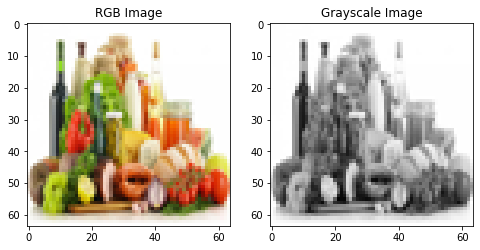

In [ ]:
i = np.random.choice(rgb_img.shape[0])
fig, axs = plt.subplots(ncols=2, figsize=(8,8))
axs[0].set_title('RGB Image')
axs[0].imshow(rgb_img[i])
axs[1].set_title('Grayscale Image')
axs[1].imshow(gs_img[i], cmap="gray")
plt.show()

In [ ]:
print(gs_img.shape, rgb_img.shape)
gs_train, gs_test, rgb_train, rgb_test = train_test_split(gs_img, rgb_img, test_size=0.2)
print(gs_train.shape, gs_test.shape, rgb_train.shape, rgb_test.shape)

(12583, 64, 64, 1) (12583, 64, 64, 3)
(10066, 64, 64, 1) (2517, 64, 64, 1) (10066, 64, 64, 3) (2517, 64, 64, 3)


The average loss when using the grayscale images as predictions for the rgb images is 0.069. Since the values of each pixel are between 0 and 1 the loss is a small number.

In [ ]:
print(image_baseline(rgb_img, gs_img))

0.06905437710548107


In [ ]:
K.clear_session()

## Models

### Baseline Model

Our baseline model is a single convolutional layer that outputs three channels for red, green and blue. We use zero padding to preserve image size of our output.

In [ ]:
# baseline model 1->3 filters
inputs = Input((imgW, imgH, 1))
x = layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="swish")(inputs)
bModel = Model(inputs, x)

In [ ]:
bModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 3)         30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bModel.compile(optimizer="rmsprop", loss=losses.MeanAbsoluteError())

In [ ]:
history = bModel.fit(gs_train, rgb_train, batch_size=16, epochs=10, validation_split=0.3)

Epoch 1/10
441/441 [==============================] - 3s 5ms/step - loss: 0.1853 - val_loss: 0.0941
Epoch 2/10
441/441 [==============================] - 2s 4ms/step - loss: 0.0891 - val_loss: 0.0843
Epoch 3/10
441/441 [==============================] - 2s 4ms/step - loss: 0.0808 - val_loss: 0.0775
Epoch 4/10
441/441 [==============================] - 2s 4ms/step - loss: 0.0754 - val_loss: 0.0738
Epoch 5/10
441/441 [==============================] - 2s 5ms/step - loss: 0.0722 - val_loss: 0.0712
Epoch 6/10
441/441 [==============================] - 2s 4ms/step - loss: 0.0705 - val_loss: 0.0698
Epoch 7/10
441/441 [==============================] - 2s 5ms/step - loss: 0.0698 - val_loss: 0.0693
Epoch 8/10
441/441 [==============================] - 2s 5ms/step - loss: 0.0693 - val_loss: 0.0690
Epoch 9/10
441/441 [==============================] - 2s 5ms/step - loss: 0.0690 - val_loss: 0.0689
Epoch 10/10
441/441 [==============================] - 2s 5ms/step - loss: 0.0688 - val_loss: 0.0686

While our baseline model produces low validation loss, when we finally see the output we see that this might not be the best metric to compare results on.

### Fully Convolutional Models

Our next models would be extensions on the base model, they use convolutional layers all the way through and do not shrink the image size thanks to the zero padding. The last layer again has 3 channels 1 each for red, green and blue.

In [ ]:
inputs = Input((imgW, imgH, 1))
x = layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="elu")(inputs)
x = layers.Conv2D(filters=32, kernel_size=7, padding="same", activation="elu")(x)
x = layers.Conv2D(filters=64, kernel_size=15, padding="same", activation="elu")(x)
x = layers.Conv2D(filters=64, kernel_size=7, padding="same", activation="elu")(x)
x = layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="elu")(x)
x = layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid")(x)
cModel = Model(inputs, x)

In [ ]:
cModel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        25120     
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        460864    
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        200768    
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        51232     
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 3)         867 

The fully convolutional models are not able to reproduce color very well. They seem to only be able to apply a uniform tint to the image. We tried adding more filters to the layers, adding layers, increasing kernel size and changing activation functions. We limited our operations to what would not modify the output shape. Though these changes do marginally reduce loss over the greyscale image, it does not satisfyingly produce color.

### Covolutional and Dense Models

Since our purely convolutional models were not able to reproduce color well we decieded to try and flatten our model and end it with a dense layer. The dense layer has three neurons per pixel so a 3 chanel RGB image can be constructed from its output. Since the dense layers are so large that is where most of the parameters end up. The final layer also ends up being the limiting factor on the size of our model, pushing the limit of the memory on our GPU. 

In [ ]:
act1 = "swish"
pad = "valid"
do2 = 0.5
inputs = Input((imgW, imgH, 1))
x = layers.Conv2D(filters=32, kernel_size=7, padding=pad, activation=act1)(inputs)
x = layers.Dropout(do2)(x)
x = layers.Conv2D(filters=32, kernel_size=5, padding=pad, activation=act1)(x)
x = layers.Dropout(do2)(x)
x = layers.Conv2D(filters=32, kernel_size=5, padding=pad, activation=act1)(x)
x = layers.Dropout(do2)(x)
x = layers.Conv2D(filters=4, kernel_size=3, padding="same", activation=act1)(x)
x = layers.Flatten()(x)
x = layers.Dense((imgW*imgH*3))(x)
model = Model(inputs, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 58, 58, 32)        1600      
                                                                 
 dropout (Dropout)           (None, 58, 58, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 32)        25632     
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        25632     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 32)        0     

In [ ]:
checkpoint_filepath = "C:\\Google_Images_Dataset\\checkpoint"
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

eStop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
model.compile(optimizer="rmsprop", loss=losses.MeanAbsoluteError())

In [ ]:
history = model.fit(
    gs_train, 
    rgb_train.reshape(rgb_train.shape[0], imgH*imgW*3), 
    batch_size=8, 
    epochs=100, 
    validation_split=0.3, 
    callbacks=[modelCheckpoint, eStop]
)

Epoch 1/100
881/881 [==============================] - 78s 86ms/step - loss: 0.1757 - val_loss: 0.1241
Epoch 2/100
881/881 [==============================] - 73s 83ms/step - loss: 0.1332 - val_loss: 0.1284
Epoch 3/100
881/881 [==============================] - 76s 86ms/step - loss: 0.1222 - val_loss: 0.1070
Epoch 4/100
881/881 [==============================] - 74s 84ms/step - loss: 0.1164 - val_loss: 0.1144
Epoch 5/100
881/881 [==============================] - 74s 85ms/step - loss: 0.1117 - val_loss: 0.1182
Epoch 6/100
881/881 [==============================] - 75s 85ms/step - loss: 0.1092 - val_loss: 0.1610
Epoch 7/100
881/881 [==============================] - 77s 87ms/step - loss: 0.1064 - val_loss: 0.0969
Epoch 8/100
881/881 [==============================] - 75s 85ms/step - loss: 0.1034 - val_loss: 0.0987
Epoch 9/100
881/881 [==============================] - 76s 86ms/step - loss: 0.1015 - val_loss: 0.0939
Epoch 10/100
881/881 [==============================] - 74s 84ms/step - l

The dense layer model on paper does not perform as well, but when looking at image output we see that it will start producing different colors compared to the baselines results. Also by changing the padding we do see a reduction in loss but the output seems to lose some detail. We also ended up keeping this since the smaller flattened layer at the end would lead to less memory errors.

In [ ]:
# eModel.load_weights(checkpoint_filepath)

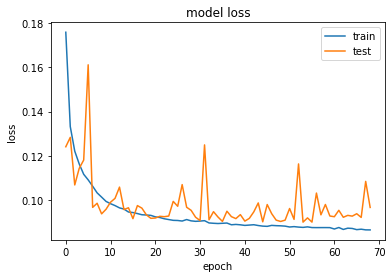

In [ ]:
plot_metric(history)

## Results

In [ ]:
img_pred = model.predict(gs_test)
baseline = bModel.predict(gs_test)

In [ ]:
print(img_pred.shape, baseline.shape)

(2517, 12288) (2517, 64, 64, 3)


In [ ]:
# MAE of current model
pred_err= np.mean(np.abs(img_pred-rgb_test.reshape(-1, imgH*imgW*3)))
base_err= np.mean(np.abs(baseline-rgb_test))
print(pred_err, base_err)

0.09185835419970687 0.06970934650702296


While mean absolute error is higher based on the color values versus the baseline, the dense model appears much better at producing colors. This suggests that this loss metric might not be the best, since rather than a uniform tint like the lower loss baseline, different sections of the image clearly have different colors. The colors also line up well with the original. One downside is the predicted images do have a lot of noise which makes them less clear. 

In the following examples we show the actual image followed by the grayscale image, followed by the image predicted by the dense model, and ended with the baseline convolutional model.

In [ ]:
test_img1 = np.random.choice(rgb_test.shape[0])
test_img2 = np.random.choice(rgb_test.shape[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


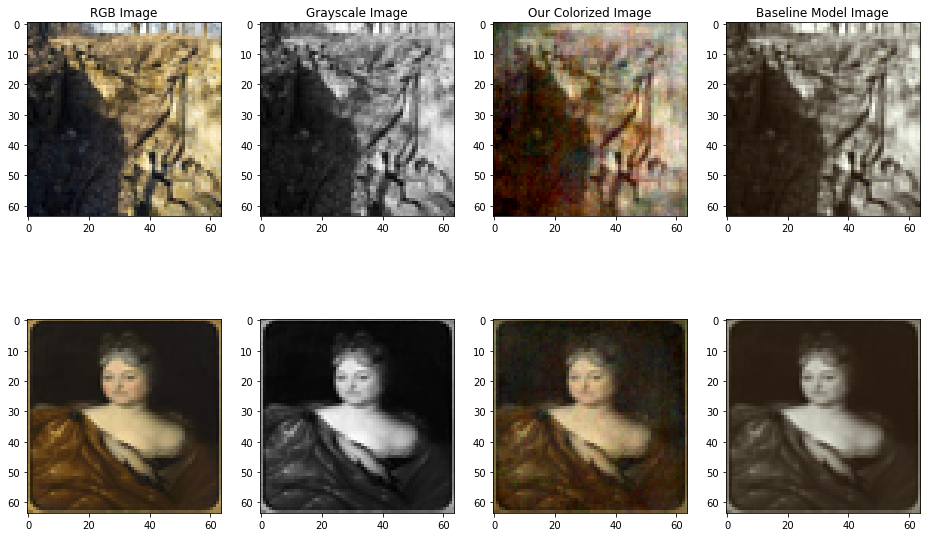

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
axs[0,0].set_title('RGB Image')
axs[0,0].imshow(rgb_test[test_img1])
axs[0,1].set_title('Grayscale Image')
axs[0,1].imshow(gs_test[test_img1], cmap="gray")
axs[0,2].set_title('Our Colorized Image')
axs[0,2].imshow(img_pred[test_img1].reshape(imgH, imgW, 3))
axs[0,3].set_title('Baseline Model Image')
axs[0,3].imshow(baseline[test_img1])
axs[1,0].imshow(rgb_test[test_img2])
axs[1,1].imshow(gs_test[test_img2], cmap="gray")
axs[1,2].imshow(img_pred[test_img2].reshape(imgH, imgW, 3))
axs[1,3].imshow(baseline[test_img2])
plt.show()

In [ ]:
test_img1 = np.random.choice(rgb_test.shape[0])
test_img2 = np.random.choice(rgb_test.shape[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


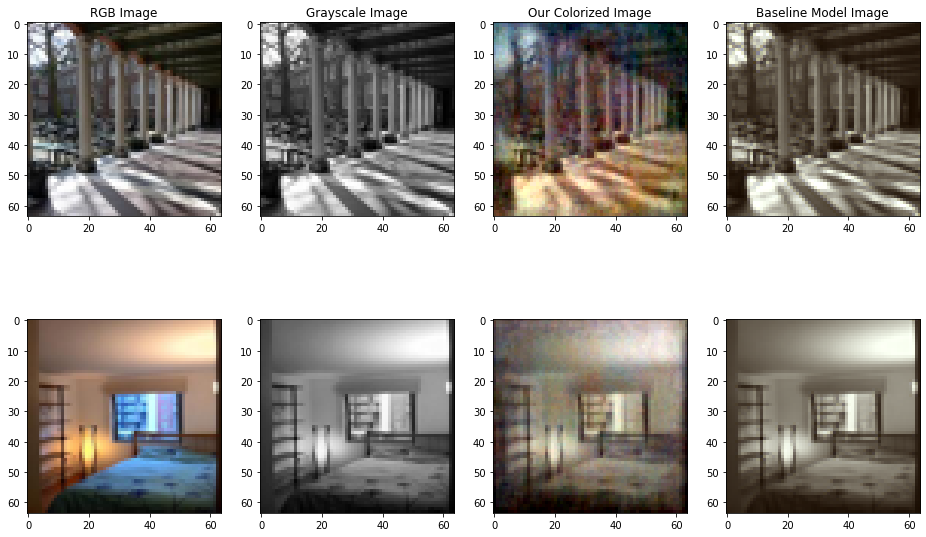

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
axs[0,0].set_title('RGB Image')
axs[0,0].imshow(rgb_test[test_img1])
axs[0,1].set_title('Grayscale Image')
axs[0,1].imshow(gs_test[test_img1], cmap="gray")
axs[0,2].set_title('Our Colorized Image')
axs[0,2].imshow(img_pred[test_img1].reshape(imgH, imgW, 3))
axs[0,3].set_title('Baseline Model Image')
axs[0,3].imshow(baseline[test_img1])
axs[1,0].imshow(rgb_test[test_img2])
axs[1,1].imshow(gs_test[test_img2], cmap="gray")
axs[1,2].imshow(img_pred[test_img2].reshape(imgH, imgW, 3))
axs[1,3].imshow(baseline[test_img2])
plt.show()

## Conclusion

Overall while not all images colorize well, by the end we acheived reasonable success in coloriziation of black and white images.

Our original fully convolutional models did not work very well for the problem. We think this may have to do with the small size of the final layer, since there were not many weights they layer couldnt effectivly give different colors to different parts of the image. We also are under the impression that since in the fully convolutional model the same kernals are ran over the whole image they might be applying similar color changes to the whole image.

The models with dense layers at the end worked much better at giving color to the different parts of the image but failed to reproduce all the original detail. We think this is because the padding shrinking of the convolutional laayers is causing detail to be lost.

If we were to continue on this project we would likely look into creating a custom loss function that might include not just how far off the red, green and blue were, but some penalty based on the color as a whole. We might also look at seperate models for the components of the colors to see how they train independently. This second one might be more insight then results but could prove useful when determining what was tinting our image. 